In [1]:
%load_ext autoreload 

from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from easydict import EasyDict as edict
import yaml
import pandas as pd

from scipy.signal import convolve2d, convolve
from scipy.signal.windows import blackman, gaussian
from scipy import stats 

import copy
from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.cluster import MeanShift
from sklearn.metrics import r2_score, make_scorer
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_swiss_roll,\
                             make_s_curve,\
                             make_moons, \
                             make_blobs

from collections import defaultdict
from joblib import Parallel, delayed
from umap import UMAP

from IPython.core.debugger import set_trace
from IPython.display import clear_output

import torch
from torch import nn
from torch import optim

from train_utils import bruteforce_projection, oja_rule, hebb_rule, GHA_rule, criterion_rule, check_nan
from metric_utils import calculate_Q_metrics, \
                         strain, \
                         to_numpy, \
                         cosine_sim, \
                         variance, \
                         get_k_th_moment   
                         
from input_utils import DataGenerator, \
                        make_random_affine, \
                        make_bicluster, \
                        make_kurtosis_first_direction, \
                        make_skewness_first_direction

from models_utils import init_weights, universal_approximator, dJ_criterion

from joblib import Parallel, delayed

plt.rcParams['font.size'] = 20
device = torch.device('cuda:0')
%autoreload 2

def absolute(fun):
    def wrapper(X):
        return np.abs(fun(X))
    return wrapper

# Criterion

In [2]:
CRIT_NAME = 'kurtosis'
k=4

SCALER = StandardScaler() 
input_parameters = {'generator': make_kurtosis_first_direction, 
                    'generator_kwargs': {'n_samples':1000, 
                                         'ktype':'neg',
                                         'offset':4,
                                         'replace_ratio':0.25}, # 1e-1
                    'unsupervised':False,
                    'scaler':SCALER,
                    'whiten':True,
                    'use_outpt_color':False
                   }


create_data = DataGenerator(**input_parameters)

inpt, outpt, _ = create_data()
inpt_tensor = torch.tensor(inpt,dtype=torch.float32)

In [3]:
# CRIT_NAME = 'skewness'
# k = 3

# SCALER = StandardScaler() 
# input_parameters = {'generator': make_skewness_first_direction, 
#                     'generator_kwargs': {'n_samples':1000, 
#                                          'stype':'pos',
#                                          'k':2}, # 1e-1
#                     'unsupervised':False,
#                     'scaler':SCALER,
#                     'whiten':True,
#                     'use_outpt_color':False
#                    }

# create_data = DataGenerator(**input_parameters)


# inpt, outpt, _ = create_data()
# inpt_tensor = torch.tensor(inpt,dtype=torch.float32)

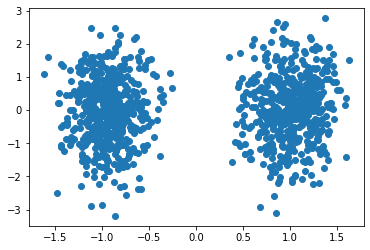

In [4]:
plt.scatter(inpt_tensor[0], inpt_tensor[1])

In [5]:
# check whitening
(inpt@inpt.T / inpt.shape[1]).round(2)

array([[1.  , 0.06],
       [0.06, 1.  ]])

In [6]:
inpt.mean(1), inpt.std(1)

(array([ 3.90798505e-17, -7.10542736e-18]), array([1., 1.]))

In [7]:

σ = 1
μ = 0

arr_mult = 5

criterion = get_k_th_moment(k, σ=σ, μ=μ)
f_criterion = lambda y: k*(y**(k-1))

# f = lambda y: k*(torch.sign(y)*(y**(k-1)))

# criterion = variance
# f = lambda y: 2*y

dJ = dJ_criterion([criterion])
y = torch.randn(1,1000)
(dJ(y) == f(y)).all()

tensor(True)

In [8]:
#stats.skew, #stats.kurtosis, #criterion,
crit_map, W_grid = bruteforce_projection(n_grid_samples=100,
                                         criterion=absolute(criterion), 
                                         X=inpt,
                                         w_min=-1,
                                         w_max=1)

crit_thr = np.percentile(crit_map.flatten(), 99.)
mask = crit_map > crit_thr
assert mask.sum() > 0

W_s_bf = W_grid[mask]

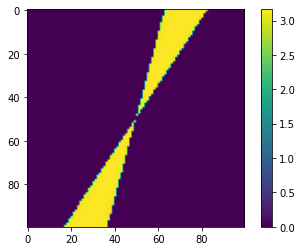

In [9]:
crit_map_bin = crit_map.copy()
crit_map_bin[crit_map_bin < np.percentile(crit_map.flatten(), 90.)] = 0
# crit_map_bin[crit_map_bin >= crit_thr] = 1

plt.imshow(np.rot90(crit_map_bin))
plt.colorbar()

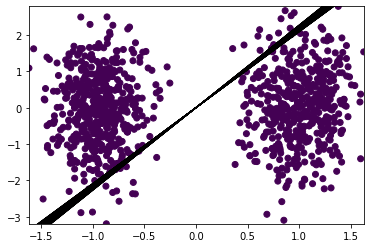

In [10]:
plt.scatter(inpt[0], inpt[1], c=outpt[0])

for w_bf in W_s_bf:
    plt.arrow(0,0,w_bf[0]*arr_mult, w_bf[1]*arr_mult, color='black')
plt.xlim(inpt[0].min(), inpt[0].max())
plt.ylim(inpt[1].min(), inpt[1].max())
plt.show()


In [11]:
# W = torch.randn(1,2,dtype=torch.float32)
# W /= W.norm()
# y = W@inpt_tensor

In [12]:
# plt.hist(x, alpha=0.5, label=criterion(x))
# plt.hist(y, alpha=0.5, label=criterion(y))
# plt.legend()
# plt.show()

In [13]:
def criterion_rule(inp, out, W):
    # equation (3)
    if isinstance(inp, torch.Tensor):
        d1,T = inp.shape
        device = W.device
        I = torch.eye(d1, device=device) 
    else:
        d1,T = inp.shape
        I = np.eye(d1) # [d1,d1]
        
    dW = (out@inp.T)@(I - W.T@W)/T # [d2,:]@[:,d1]@([d1,d1] - [d1,d1]) 
    return dW

In [14]:
# def criterion_rule(inp, out, W):
#     # equation (3)
#     if isinstance(inp, torch.Tensor):
#         d1,T = out.shape
#         device = W.device
#         I = torch.eye(d1, device=device) 
#     else:
#         d1,T = out.shape
#         I = np.eye(d1) # [d1,d1]
        
#     dW = (I - W@W.T)@(out@inp.T)/T # [d2,:]@[:,d1]@([d1,d1] - [d1,d1]) 
#     return dW

In [15]:
# # initialize
# W = torch.randn(1,2)
# W /= torch.norm(W)
# results = defaultdict(list)

# t = 0

# inp = inpt_tensor[:,t:t+dt]
# out = f(W@inp)

# lr = min(5e-4, 2./inp.norm())
# dW = learning_rule(inp, out, W)
# W = W + lr*dW

# d1,T = inp.shape
# device = W.device
# I = torch.eye(d1, device=device) 

think why for single neuron $(I - W^TW)$ is unsolvable - maybe a typo somewhere

In [16]:
learning_rule = hebb_rule #hebb_rule #criterion_rule

n_trials = 100
max_epochs = 1000

T = inpt.shape[1]
dt = 1 # T//4

# crit_rtol = 1e-1*crit_thr # abs tolerance for early stopping

############
# learning #
############
def train(inpt_tensor, f, W=None, max_plateu_epochs=50, normalize_W=True):
    
    results = defaultdict(list)
    
    # initialize
    if W is None:
        W = torch.randn(1,2)
        W /= torch.norm(W, dim=1, keepdim=True)
    
    for epoch in range(max_epochs):
        for t in list(range(0,T,dt)):

            inp = inpt_tensor[:,t:t+dt]
            out = f(W@inp)
            
            lr = min(5e-4, 2./inp.norm())
            dW = learning_rule(inp, out, W)
            W = W + lr*dW
            
            # stuff for stability
            if torch.isnan(W).any():
                raise RuntimeError()
            if normalize_W:
                W /= torch.norm(W, dim=1, keepdim=True)
                
            results['W'] = W

        # calculate criterion
        W_n = to_numpy(W).copy()
        W_n /= np.linalg.norm(W_n, axis=1, keepdims=True)
        out_all = W_n@inpt #[2,T]
        
#         for i in range(out_all.shape[0]):
#             Js = absolute(criterion)(out_all[i])
#             results[f'Js_{i}'].append(Js)
        
        Js = absolute(criterion)(out_all)
        results[f'Js'].append(Js)
            
        results['W_n_s'].append(W_n.flatten())
        
        # exit conditions 
        if epoch > max_plateu_epochs:
            W_n_s_std = np.stack(results['W_n_s'][-max_plateu_epochs:]).std(0)
            if W_n_s_std.max() < 1e-1:
                break

        if Js >= crit_thr:
            break
    
    return results
    
    
results = Parallel(n_jobs=-1)(delayed(train)(inpt_tensor, f=f_criterion) 
                    for _ in tqdm(range(n_trials)))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


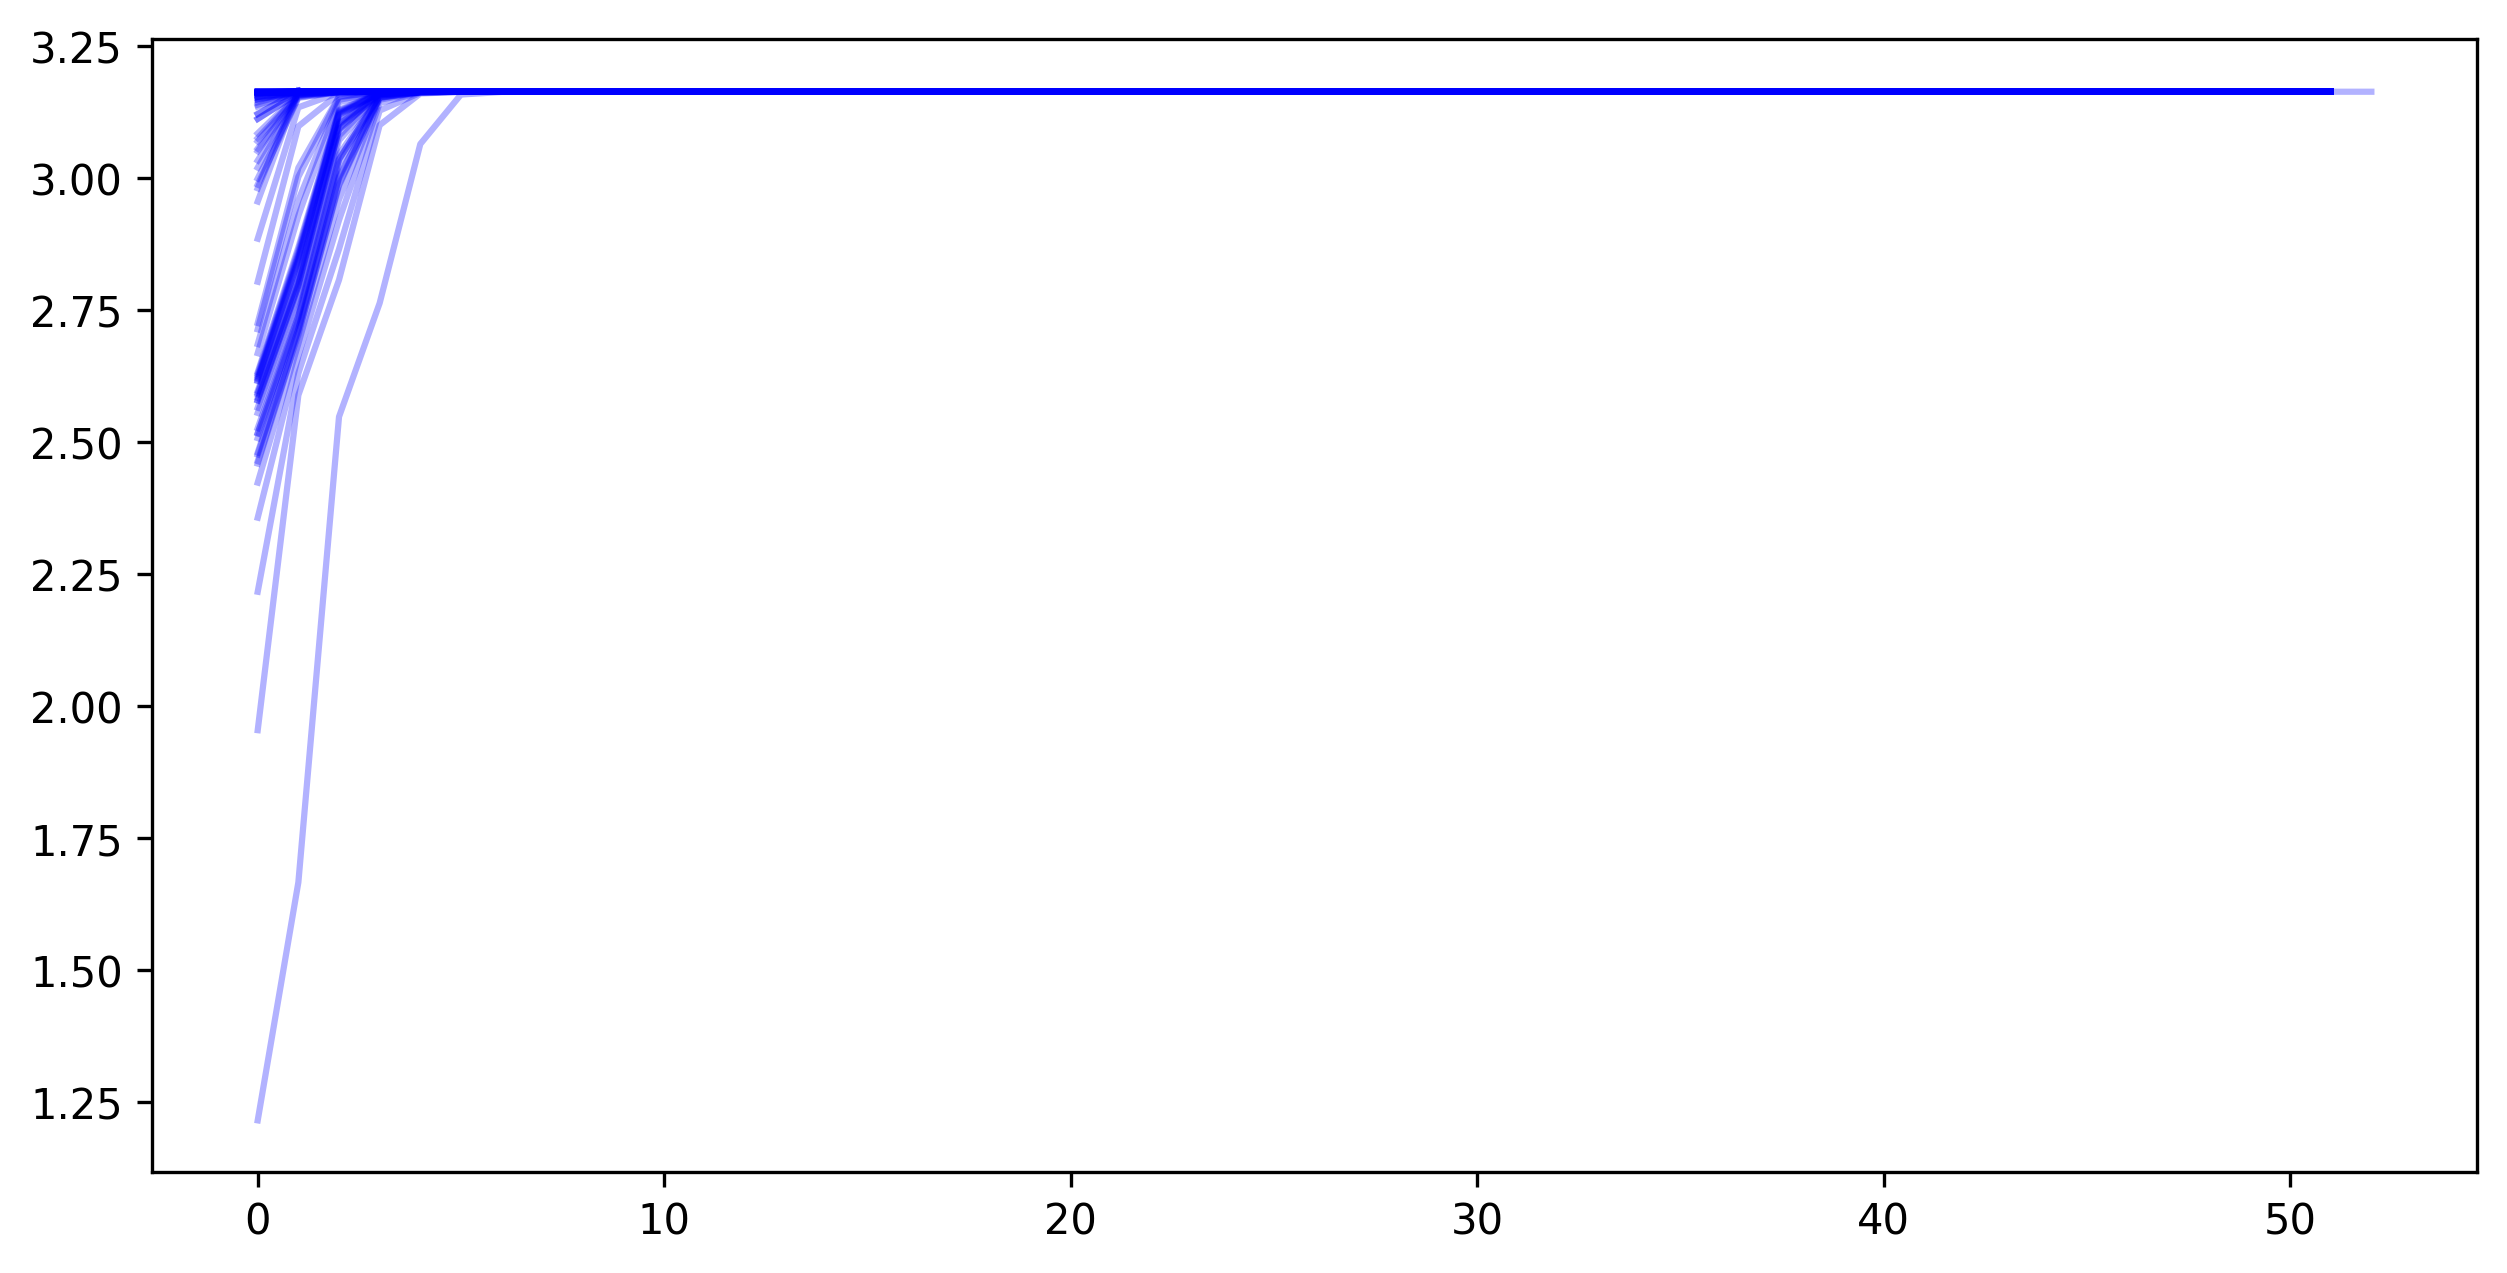

In [17]:
plt.figure(figsize=(10,5), dpi=300)
for results_sample in results:
    Js = results_sample['Js']
    plt.plot(np.arange(len(Js)), Js, color='blue', alpha=0.3)

In [18]:
# maxlen = max([(results_sample['Js'] < crit_thr-1).sum() for results_sample in results]) + 3

# plt.figure(figsize=(10,5), dpi=300)
# for results_sample in results:
#     Js = results_sample['Js']
#     # length of threshold line
# #     maxlen = len(Js) if len(Js)>maxlen else maxlen
#     plt.plot(np.arange(maxlen)[:len(Js[:maxlen])], \
#              Js[:maxlen], color='blue', alpha=0.3)
    
# plt.hlines(crit_thr, 0,
#            maxlen,
#            linestyle='--', color='red', linewidth=3, label=f'Maximum {CRIT_NAME}')
# plt.xlabel('# epochs')
# plt.ylabel(CRIT_NAME)

# plt.legend(loc='lower right')
# plt.show()

In [19]:
# maxlen = max([(results_sample['Js_1'] < crit_thr-1).sum() for results_sample in results]) + 3

# plt.figure(figsize=(10,5), dpi=300)
# for results_sample in results:
#     Js = results_sample['Js_1']
#     # length of threshold line
# #     maxlen = len(Js) if len(Js)>maxlen else maxlen
#     plt.plot(np.arange(maxlen)[:len(Js[:maxlen])], Js[:maxlen], color='blue', alpha=0.3)
    
# plt.hlines(crit_thr, 0,
#            maxlen,
#            linestyle='--', color='red', linewidth=3, label=f'Maximum {CRIT_NAME}')
# plt.xlabel('# epochs')
# plt.ylabel(CRIT_NAME)

# plt.legend(loc='lower right')
# plt.show()

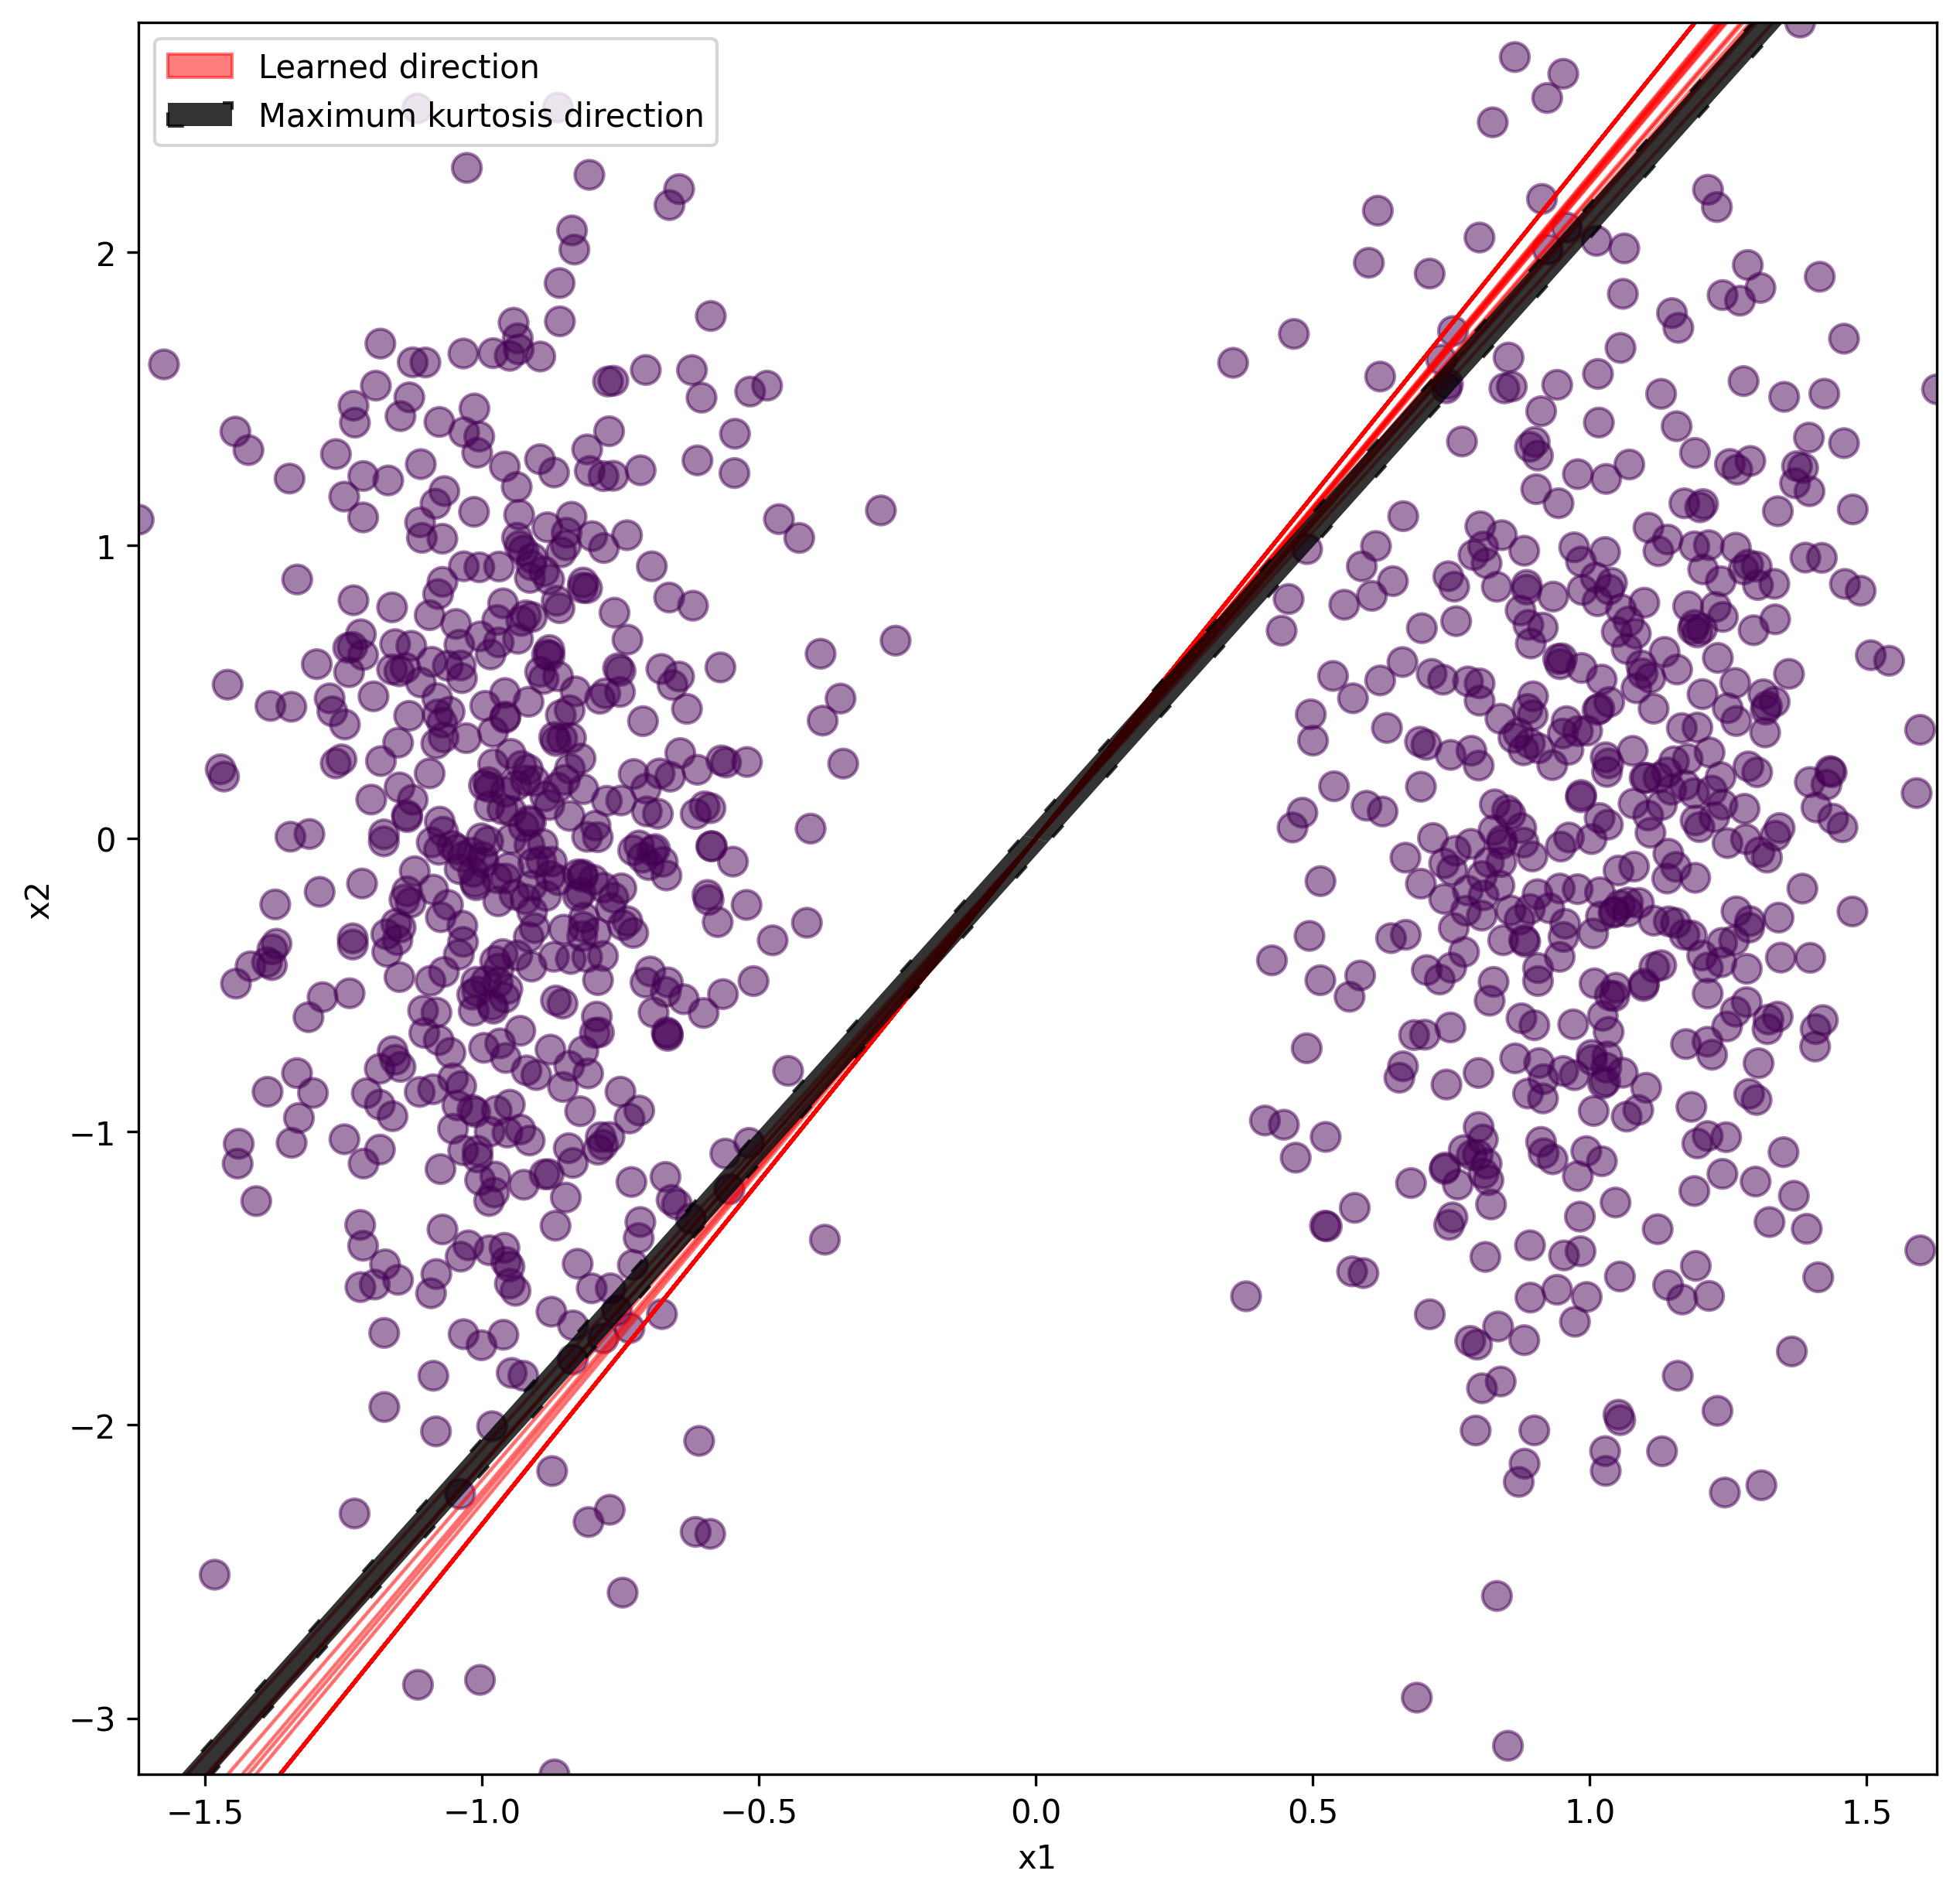

In [20]:
plt.figure(figsize=(10,10), dpi=300)

plt.scatter(inpt[0], inpt[1], c=outpt[0], alpha=0.5, s=80)

sims_all = []
for sample_num, results_sample in enumerate(results):
    W = results_sample['W_n_s'][-1]
    plt.arrow(0,0,W[0]*arr_mult,W[1]*arr_mult, color='red', \
              label='Learned direction' if sample_num==0 else None, alpha=0.5)    

#     sims = []
#     for w_bf in W_s_bf:
#         sims.append(np.abs(cosine_sim(w_bf, W[0])))
#     sims_all.append(max(sims))

for w_bf_num, w_bf in enumerate(W_s_bf):
    plt.arrow(0,0,w_bf[0]*arr_mult, w_bf[1]*arr_mult, color='black', alpha=.8, \
              label=f'Maximum {CRIT_NAME} direction' if w_bf_num==0 else None, \
              width=.05, linestyle=(0, (5, 20)))
    
    plt.arrow(0,0,-w_bf[0]*arr_mult, -w_bf[1]*arr_mult, color='black', alpha=.8, \
              width=.05, linestyle=(0, (5, 20)))
    break

plt.xlim(inpt[0].min(), inpt[0].max())
plt.ylim(inpt[1].min(), inpt[1].max())
plt.xlabel('x1')
plt.ylabel('x2')
# plt.title('Min Cosyne sim: {:.3f}'.format(min(sims_all)))
plt.legend()
plt.show()

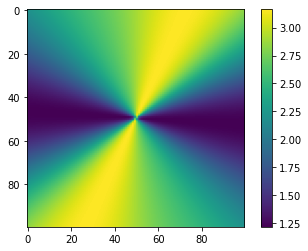

In [21]:

plt.imshow(np.rot90(crit_map))
plt.colorbar()
plt.show()

# Metalearn

In [66]:
f_θ = universal_approximator(1, requires_grad = True)

In [67]:
W_reference = torch.tensor(W_s_bf[0][None,:], dtype=torch.float32)
W = torch.randn(1,2)
W /= torch.norm(W, dim=1, keepdim=True)
W.requires_grad_(True)

tensor([[-0.9224, -0.3862]], requires_grad=True)

In [68]:
f_θ(inpt_tensor).shape

torch.Size([2, 1000])

In [76]:
criterion_history = []
sims_history = []

# for p in range(100):

sim = 1 - (W@W_reference.T).abs()
# W /= torch.norm(W, dim=1, keepdim=True)
out = f(W@inpt_tensor)
# loss = absolute(criterion)(out)
loss = -criterion(out)**2

In [75]:
loss

tensor(1.8255e+09, grad_fn=<PowBackward0>)